In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
from functools import partial

import gymnasium as gym
import numpy as np
import seaborn as sns
import torch as t
from gymnasium.envs.registration import EnvSpec
from matplotlib import pyplot as plt
from rich.pretty import pprint as pp
from tqdm import tqdm

from bert_sac.models import Actor, SoftQNetwork
from bert_sac.sac_trainer import AntSAC, AntSACConfig
from bert_sac.utils import make_env

ppe = partial(pp, expand_all=True)

SEED = 999

device = t.device("cuda:0")
t.set_default_device(device)

{'ATT_MASK.shape': torch.Size([27, 27])}

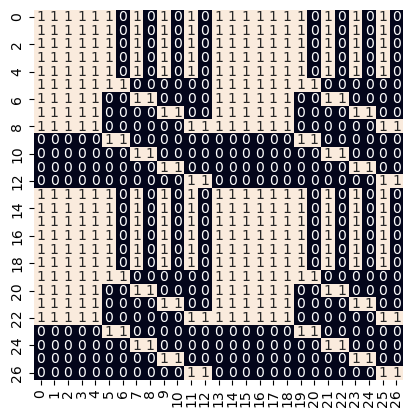

In [3]:
NUM_STRUCT_ELEMENTS = 9

ATT_MASK = t.tensor(
    [
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1],
        [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
    ]
)

pp({"ATT_MASK.shape": ATT_MASK.shape})

sns.heatmap(ATT_MASK.cpu(), square=True, cbar=False, annot=True)
plt.show()

In [4]:
envs = gym.vector.AsyncVectorEnv([make_env("Ant-v4", seed=SEED) for _ in range(4)])

In [5]:
envs.reset()[0].shape

(4, 27)

In [6]:
sac_config = AntSACConfig(n_legs=4, seed=SEED, checkpoint_frequency=20_000)

In [7]:
sac = AntSAC(
    actor_net=Actor,
    critic_net=SoftQNetwork,
    envs=envs,
    num_obs=27,
    num_act=8,
    device=device,
    attention_mask=ATT_MASK,
    config=sac_config,
    artifact_path="./artifacts",
    num_att_layers=4,
)
sac.global_step

0

In [8]:
# sac.load_from_checkpoint("artifacts/checkpoints/Ant-v4__999__20240607-104136.tar")

In [9]:
sac

AntSAC(
  (actor): Actor(
    (preprocess_layer): Sequential(
      (0): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (1): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (2): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (3): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
    )
    (fc): Sequential(
      (0): Linear(in_features=27, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=8, bias=True)
    (fc_logstd): Linear(in_features=256, out_features=8, bias=True)
  )
  (qf1): SoftQNetwork(
    (preprocess_layer): Sequential(
      (0): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (1): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (2): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (3): AttentionLayer(
        (softmax): Softmax(dim=1)


In [10]:
import warnings

warnings.filterwarnings("ignore")

sac.train(500_000)

  0%|          | 0/500000 [00:00<?, ?it/s]

100%|██████████| 500000/500000 [3:44:25<00:00, 37.13it/s]  


In [12]:
# sac.save_checkpoint(sac.global_step)

In [13]:
obs_env = gym.make("Ant-v4", render_mode="rgb_array")
obs_env = gym.wrappers.RecordVideo(
    obs_env,
    video_folder="artifacts/recordings",
    episode_trigger=lambda t: t % 1 == 0
)
obs_env

<RecordVideo<TimeLimit<OrderEnforcing<PassiveEnvChecker<AntEnv<Ant-v4>>>>>>

In [14]:
sac

AntSAC(
  (actor): Actor(
    (preprocess_layer): Sequential(
      (0): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (1): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (2): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (3): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
    )
    (fc): Sequential(
      (0): Linear(in_features=27, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ReLU()
    )
    (fc_mean): Linear(in_features=256, out_features=8, bias=True)
    (fc_logstd): Linear(in_features=256, out_features=8, bias=True)
  )
  (qf1): SoftQNetwork(
    (preprocess_layer): Sequential(
      (0): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (1): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (2): AttentionLayer(
        (softmax): Softmax(dim=1)
      )
      (3): AttentionLayer(
        (softmax): Softmax(dim=1)


In [15]:
obs, info = obs_env.reset()
for _ in tqdm(range(5_000)):
    obs = t.Tensor(obs).to(sac.device)
    actions, _, _ = sac.actor.get_action0(obs)
    obs, reward, terminated, truncated, info = obs_env.step(
        actions.view(
            8,
        )
        .detach()
        .cpu()
        .numpy()
    )
    if terminated or truncated:
        obs, info = obs_env.reset()


 20%|█▉        | 985/5000 [00:05<00:23, 171.22it/s]

Moviepy - Building video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-0.mp4



 20%|██        | 1021/5000 [00:10<04:43, 14.05it/s]

Moviepy - Done !
Moviepy - video ready c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-0.mp4


 28%|██▊       | 1387/5000 [00:13<00:21, 164.25it/s]

Moviepy - Building video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-1.mp4



 28%|██▊       | 1422/5000 [00:15<01:46, 33.64it/s] 

Moviepy - Done !
Moviepy - video ready c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-1.mp4


 48%|████▊     | 2379/5000 [00:20<00:12, 214.48it/s]

Moviepy - Building video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-2.mp4.
Moviepy - Writing video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-2.mp4



 48%|████▊     | 2425/5000 [00:25<02:04, 20.65it/s] 

Moviepy - Done !
Moviepy - video ready c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-2.mp4


 68%|██████▊   | 3393/5000 [00:29<00:07, 226.61it/s]

Moviepy - Building video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-3.mp4.
Moviepy - Writing video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-3.mp4



 69%|██████▉   | 3438/5000 [00:34<01:14, 20.83it/s] 

Moviepy - Done !
Moviepy - video ready c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-3.mp4


 87%|████████▋ | 4371/5000 [00:38<00:02, 225.95it/s]

Moviepy - Building video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-4.mp4.
Moviepy - Writing video c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-4.mp4



 89%|████████▉ | 4444/5000 [00:43<00:18, 30.03it/s] 

Moviepy - Done !
Moviepy - video ready c:\Users\COCUTERSASHA\Desktop\ohMy\new_life\artifacts\recordings\rl-video-episode-4.mp4


100%|██████████| 5000/5000 [00:46<00:00, 108.42it/s]
